##### STAGE 03 - FEATURE ENGINEERING AND DATA TRANSFORMATION (NUMERICAL AND CATEGORICAL ENCODING)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

###### Load the cleaned data from data/preprocessed_data

In [2]:
train_data = pd.read_csv("../data/processed_data/cleaned_training_data.csv")
eval_data = pd.read_csv("../data/processed_data/cleaned_evaluation_data.csv")
holdout_data = pd.read_csv("../data/processed_data/cleaned_holdout_data.csv")

print(f"Train data shape: {train_data.shape}")
print(f"Eval data shape: {eval_data.shape}")
print(f"Holdout data shape: {holdout_data.shape}")

Train data shape: (576815, 41)
Eval data shape: (148448, 41)
Holdout data shape: (148943, 41)


###### ENGINEERING DATE FEATURES WITH `DATE`

In [3]:
print(f"Training data date range: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Evaluation data date range: {eval_data['date'].min()} to {eval_data['date'].max()}")
print(f"Holdout data date range: {holdout_data['date'].min()} to {holdout_data['date'].max()}")

Training data date range: 2012-03-31 to 2019-12-31
Evaluation data date range: 2020-01-31 to 2021-12-31
Holdout data date range: 2022-01-31 to 2023-12-31


In [4]:
print(train_data.columns.tolist())

['date', 'median_sale_price', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'city', 'zipcode', 'year', 'bank', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'supermarket', 'Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty', 'Total Housing Units', 'Median Rent', 'Median Home Value', 'Total Labor Force', 'Unemployed Population', 'Total School Age Population', 'Total School Enrollment', 'Median Commute Time', 'price', 'city_full', 'lat', 'lng']


In [5]:
def engineer_date_features(df, col_name="date"):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year

    # DROP THE ORIGINAL DATE COLUMN
    df = df.drop(columns=[col_name])

    # REORDERING COLUMNS TO PLACE THE NEW DATE FEATURES AT THE FRONT
    # new_order = ['month', 'quarter', 'year'] + [col for col in df.columns if col not in ['month', 'quarter', 'year']]
    # df = df[new_order]

    df.insert(0, "month", df.pop("month"))
    df.insert(1, "quarter", df.pop("quarter"))
    df.insert(2, "year", df.pop("year"))

    return df

In [6]:
train_df = engineer_date_features(train_data)
eval_df = engineer_date_features(eval_data)
holdout_df = engineer_date_features(holdout_data)
print(train_df.columns.tolist())
print(f"Train data shape after date feature engineering: {train_df.shape}")
print(f"Eval data shape after date feature engineering: {eval_df.shape}")
print(f"Holdout data shape after date feature engineering: {holdout_df.shape}")

['month', 'quarter', 'year', 'median_sale_price', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'city', 'zipcode', 'bank', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'supermarket', 'Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty', 'Total Housing Units', 'Median Rent', 'Median Home Value', 'Total Labor Force', 'Unemployed Population', 'Total School Age Population', 'Total School Enrollment', 'Median Commute Time', 'price', 'city_full', 'lat', 'lng']
Train data shape after date feature engineering: (576815, 42)
Eval data shape after date feature engineering: (148448, 42)
Holdout data shape after date feature engineering: (148943, 42)


`I would reserve the data here for the purpose of training a tree-based model that needs not to be scaled`

In [7]:
train = train_df.copy()
eval = eval_df.copy()
holdout = holdout_df.copy()

##### TESTING FOR MULTICOLLINEARITY

- Multicollinearity in regression model is when two or more features are highly correlated with each other. 

- It is important to note that multicollinearity distort regression estimates, inflate coefficient variances and make models unstable. 

- One of the way approach to identify multicollinearity is using the `Variance Inflation Factor (VIF)`. 

- VIF is statistical measure used for detecting the features that are causing multicollinearity. It quantifies how much the variance of a regression coefficient increases due to multicollinearity.

###### INTERPRETING `VIF` Values
VIF             --------------------------------                      MEANING

- `1`                                     No correlation with other variables --->> Ideal and expected situation.

- `1 - 5`                                 Moderate correlation --->> Acceptance in most models.

- `> 5`                                   Problematic multicollinearity ---> Investigate.

- `> 10`                                  Serious or Abnormal multicollinearity --->> Remove or Transform the feature.

###### Why VIF matters in Feature Selection
- When features are strongly correlated:

    - Coefficients become unstable,

    - Standard errors inflate,

    - Model interpretation becomes unreliable,

    - Small data changes lead to big coefficient swings.

###### STRATEGY FOR VIF
- Compute VIF on the features,
- Identify any features with high VIF usually between `> 5 or > 10`,
- Remove the feature with the `highest VIF` first,
- Recompute the VIF again,
- Continue until all VIF values are acceptable.


###### FUNCTION FOR COMPUTING `VIF`

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_VIF(df, target_col=None):
    
    features_df = df.drop(columns=[target_col])
    num_features_df = features_df.select_dtypes(include=[np.number])
    vif_data_df = pd.DataFrame()
    vif_data_df["num_features_cols"] = num_features_df.columns
    vif_data_df["VIF_values"] = [round(variance_inflation_factor(num_features_df.values, k),0) for k in range(num_features_df.shape[1])]

    return vif_data_df.sort_values(by="VIF_values", ascending=False).reset_index(drop=True)

In [9]:
vif_table = compute_VIF(train_df, target_col="price")
print(vif_table)

c:\Users\Olanrewaju Adegoke\UV\ML_with_uv_E2E\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


               num_features_cols  VIF_values
0    Total School Age Population         inf
1        Total School Enrollment         inf
2               Total Population     14721.0
3              Total Labor Force      1879.0
4            Median Commute Time      1458.0
5   Total Families Below Poverty      1274.0
6                           year       656.0
7                            lng       492.0
8               avg_sale_to_list       371.0
9                        quarter       108.0
10                         month        83.0
11                           lat        79.0
12                       zipcode        50.0
13           Total Housing Units        50.0
14                  new_listings        42.0
15                    homes_sold        29.0
16                    Median Age        28.0
17         Unemployed Population        23.0
18                   Median Rent        21.0
19             Per Capita Income        19.0
20             Median Home Value        19.0
21        

###### `CASE 1: DROP ALL EXTREMELY REDUNCTANT COLUMNS WITH VIF >= 1000` FROM ALL THE DATASET

In [10]:
OFFSETS_COLUMNS = vif_table[vif_table['VIF_values'] >= 1000]['num_features_cols'].tolist()
print(f"Columns to drop due to high VIF: {OFFSETS_COLUMNS}")

Columns to drop due to high VIF: ['Total School Age Population', 'Total School Enrollment', 'Total Population', 'Total Labor Force', 'Median Commute Time', 'Total Families Below Poverty']


In [11]:
train_df = train_df.drop(columns=OFFSETS_COLUMNS)
eval_df = eval_df.drop(columns=OFFSETS_COLUMNS)
holdout_df = holdout_df.drop(columns=OFFSETS_COLUMNS)
print(f"Train data shape after dropping high VIF columns: {train_df.shape}")
print(f"Eval data shape after dropping high VIF columns: {eval_df.shape}")
print(f"Holdout data shape after dropping high VIF columns: {holdout_df.shape}")

Train data shape after dropping high VIF columns: (576815, 36)
Eval data shape after dropping high VIF columns: (148448, 36)
Holdout data shape after dropping high VIF columns: (148943, 36)


###### CORRELATION ANALYSIS OF FEATURES WITH THE TARGET 

C:\Users\Olanrewaju Adegoke\AppData\Local\Temp\ipykernel_25900\460183692.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.barplot(x=corr_with_target.index, y=corr_with_target.values, palette="viridis")


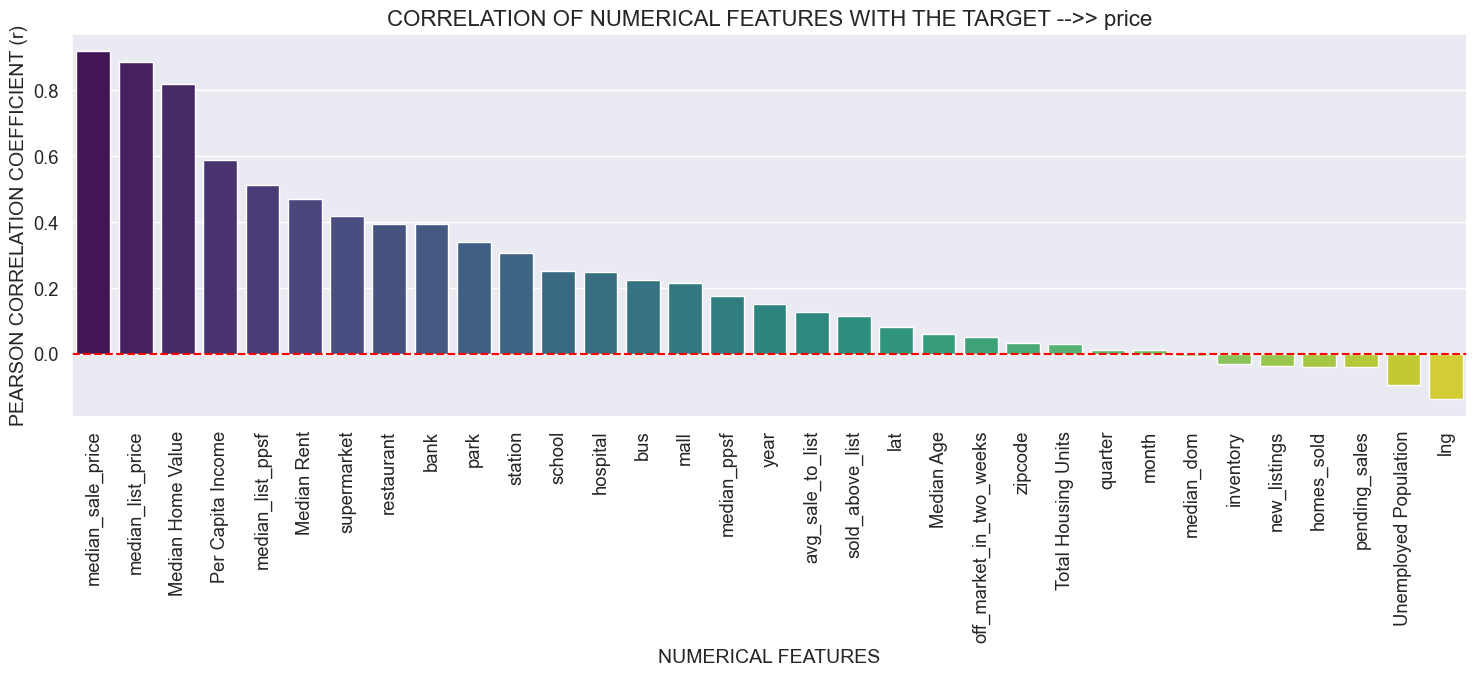

In [12]:
def features_correlation_with_target(df, target_col=None):
    features = df.drop(columns=[target_col])
    num_features = df.select_dtypes(include=[np.number])

    if target_col not in num_features.columns:
        raise ValueError(f"Target column '{target_col}' is not a numerical feature in the dataframe.")
    
    corr_with_target = num_features.corr(method='pearson')[target_col].drop(target_col).sort_values(ascending=False)

    sb.set_theme(style="whitegrid")
    sb.set(font_scale=1.2)
    plt.figure(figsize=(15, 7))
    ax = sb.barplot(x=corr_with_target.index, y=corr_with_target.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.title(f"CORRELATION OF NUMERICAL FEATURES WITH THE TARGET -->> {target_col}", fontsize=16)
    plt.xlabel("NUMERICAL FEATURES", fontsize=14)
    plt.ylabel("PEARSON CORRELATION COEFFICIENT (r)", fontsize=14)
    plt.axhline(0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()


features_correlation_with_target(train_df, target_col="price")


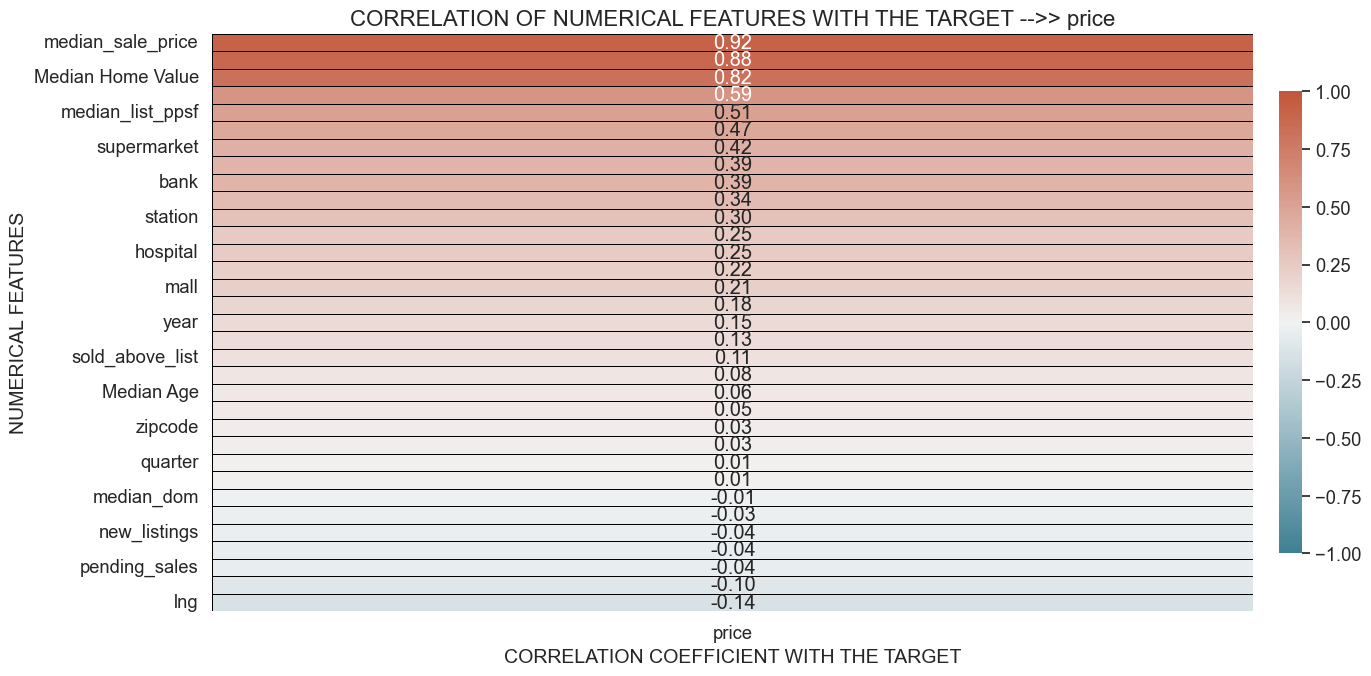

In [13]:
def features_correlation_with_target(df, target_col=None):
    
    num_features = df.select_dtypes(include=[np.number])

    if target_col not in num_features.columns:
        raise ValueError(f"Target column '{target_col}' is not a numerical feature in the dataframe.")
    
    corr_with_target = num_features.corr(method='pearson')[target_col].drop(target_col).sort_values(ascending=False)

    sb.set_theme(style="whitegrid")
    sb.set(font_scale=1.2)
    plt.figure(figsize=(15, 7))
    ax = sb.heatmap(
        corr_with_target.to_frame(),
        annot=True,
        fmt=".2f",
        cmap=sb.diverging_palette(220, 20, as_cmap=True),
        center=0,
        cbar_kws={"shrink": 0.8, "pad":0.02},
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='black'
    )

    ax.set_title(f"CORRELATION OF NUMERICAL FEATURES WITH THE TARGET -->> {target_col}", fontsize=16)
    ax.set_xlabel("CORRELATION COEFFICIENT WITH THE TARGET", fontsize=14)
    ax.set_ylabel("NUMERICAL FEATURES", fontsize=14)
    plt.tight_layout()
    plt.show()


features_correlation_with_target(train_df, target_col="price")

###### CASE 2: DROP ALL HIGHLY CORRELATED FEATURES WITH THE TARGET

In [14]:
CORRELATED_COLS = ["median_sale_price", "Median Home Value", "median_list_ppsf", "supermarket", "bank"]

train_df = train_df.drop(columns=CORRELATED_COLS)
eval_df = eval_df.drop(columns=CORRELATED_COLS)
holdout_df = holdout_df.drop(columns=CORRELATED_COLS)
print(f"Train data shape after dropping high correlated features: {train_df.shape}")
print(f"Eval data shape after dropping high correlated features: {eval_df.shape}")
print(f"Holdout data shape after dropping high correlated features: {holdout_df.shape}")

Train data shape after dropping high correlated features: (576815, 31)
Eval data shape after dropping high correlated features: (148448, 31)
Holdout data shape after dropping high correlated features: (148943, 31)


`Drop all highly correlated features for the reserved dataset`

In [15]:
train = train.drop(columns=CORRELATED_COLS)
eval = eval.drop(columns=CORRELATED_COLS)
holdout = holdout.drop(columns=CORRELATED_COLS)
print(f"Train data shape after dropping high correlated features for reserved dataset: {train.shape}")
print(f"Eval data shape after dropping high correlated features for reserved dataset: {eval.shape}")
print(f"Holdout data shape after dropping high correlated features for reserved dataset: {holdout.shape}")

Train data shape after dropping high correlated features for reserved dataset: (576815, 37)
Eval data shape after dropping high correlated features for reserved dataset: (148448, 37)
Holdout data shape after dropping high correlated features for reserved dataset: (148943, 37)


#### ENGINEERING OTHER FEATURES FROM NUMERICAL AND CATEGORICAL FEATURES
`I would be using the training data to see what feature is possible to engineer`

In [16]:
len(train_df.select_dtypes(include=[np.number]).columns.tolist())
len(train_df.select_dtypes(include=["object"]).columns.tolist())
print(f"Available columns for feature engineering:\n {train_df.columns.tolist()}")

Available columns for feature engineering:
 ['month', 'quarter', 'year', 'median_list_price', 'median_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'city', 'zipcode', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'Median Age', 'Per Capita Income', 'Total Housing Units', 'Median Rent', 'Unemployed Population', 'price', 'city_full', 'lat', 'lng']


##### `The zipcode will be engineered using frequency encoding by mapping the count of each zipcode while replacing null with 0.`

- I built the frequency map on the zipcode counts on the given dataset.

In [17]:
def engineer_zipcode_frequency_encoding(df, col_name=None):
    zipcode_counts = df[col_name].value_counts()
    df[f"{col_name}_freq"] = df[col_name].map(zipcode_counts)
    df[f"{col_name}_freq"] = df[f"{col_name}_freq"].fillna(0)
    print(f"Zipcode and Zipcode_freq:\n {df[[col_name, f'{col_name}_freq']].head(2)}")
    return df

In [18]:
col_name = "zipcode"
train_df = engineer_zipcode_frequency_encoding(train_df, col_name=col_name)
eval_df = engineer_zipcode_frequency_encoding(eval_df, col_name=col_name)
holdout_df = engineer_zipcode_frequency_encoding(holdout_df, col_name=col_name)

Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    30002            94
1    15469            86
Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    60482            24
1    41071            24
Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    32771            24
1    33778            24


`The zipcode will be engineered using frequency encoding by mapping the count of each zipcode while replacing null with 0 for the reserved dataset.`

In [19]:
train = engineer_zipcode_frequency_encoding(train, col_name=col_name)
eval = engineer_zipcode_frequency_encoding(eval, col_name=col_name)
holdout = engineer_zipcode_frequency_encoding(holdout, col_name=col_name)

Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    30002            94
1    15469            86
Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    60482            24
1    41071            24
Zipcode and Zipcode_freq:
    zipcode  zipcode_freq
0    32771            24
1    33778            24


##### `Encode the city_full using TargetEncoder with fit_transform on the training data and transform on evaluation and holdout datasets.` 
- This works because the city_full is a categorical features.

In [20]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder(cols=["city_full"])
train_df["city_full_encoded"] = target_encoder.fit_transform(train_df["city_full"], train_df["price"])
eval_df["city_full_encoded"] = target_encoder.transform(eval_df["city_full"])
holdout_df["city_full_encoded"] = target_encoder.transform(holdout_df["city_full"])

print(f"City full and city full encoded for training data:\n {train_df[['city_full', 'city_full_encoded']].head(2)}")

City full and city full encoded for training data:
                        city_full  city_full_encoded
0  Atlanta-Sandy Springs-Roswell      192627.058387
1                     Pittsburgh      131828.753854


`Encode the city_full using TargetEncoder with fit_transform on the training data and transform on evaluation and holdout datasets for the reserved datasets.`

In [21]:
train["city_full_encoded"] = target_encoder.fit_transform(train["city_full"], train["price"])
eval["city_full_encoded"] = target_encoder.transform(eval["city_full"])
holdout["city_full_encoded"] = target_encoder.transform(holdout["city_full"])

print(f"City full and city full encoded for training data for the reserved dataset:\n {train[['city_full', 'city_full_encoded']].head(2)}")

City full and city full encoded for training data for the reserved dataset:
                        city_full  city_full_encoded
0  Atlanta-Sandy Springs-Roswell      192627.058387
1                     Pittsburgh      131828.753854


##### SELECTING RELEVANT FEATURES TO ADVANCE TO THE NEXT STAGE

-    - To achieve this, I would be leveraging on case 1 and 2 repeatedly, that is, `VIF and correlation matrix`

#### `VIF`

In [22]:
vif_table = compute_VIF(train_df, target_col="price")
print(vif_table)

          num_features_cols  VIF_values
0                      year      1072.0
1                       lng       564.0
2              zipcode_freq       443.0
3          avg_sale_to_list       370.0
4                   quarter       108.0
5                     month        83.0
6                       lat        78.0
7                   zipcode        57.0
8              new_listings        41.0
9                homes_sold        28.0
10               Median Age        26.0
11            pending_sales        18.0
12              Median Rent        18.0
13      Total Housing Units        16.0
14        Per Capita Income        14.0
15        city_full_encoded        12.0
16                inventory        10.0
17                   school         9.0
18    Unemployed Population         8.0
19                     park         7.0
20          sold_above_list         5.0
21                  station         5.0
22                 hospital         4.0
23  off_market_in_two_weeks         4.0


In [23]:
OFFSETS_COLUMNS = vif_table[vif_table['VIF_values'] > 5]['num_features_cols'].tolist()

train_df = train_df.drop(columns=OFFSETS_COLUMNS)
eval_df = eval_df.drop(columns=OFFSETS_COLUMNS)
holdout_df = holdout_df.drop(columns=OFFSETS_COLUMNS)
print(f"Train data shape after dropping high VIF columns: {train_df.shape}")
print(f"Eval data shape after dropping high VIF columns: {eval_df.shape}")
print(f"Holdout data shape after dropping high VIF columns: {holdout_df.shape}")

Train data shape after dropping high VIF columns: (576815, 13)
Eval data shape after dropping high VIF columns: (148448, 13)
Holdout data shape after dropping high VIF columns: (148943, 13)


#### `CORRELATION MATRIX WITH THE TARGET`

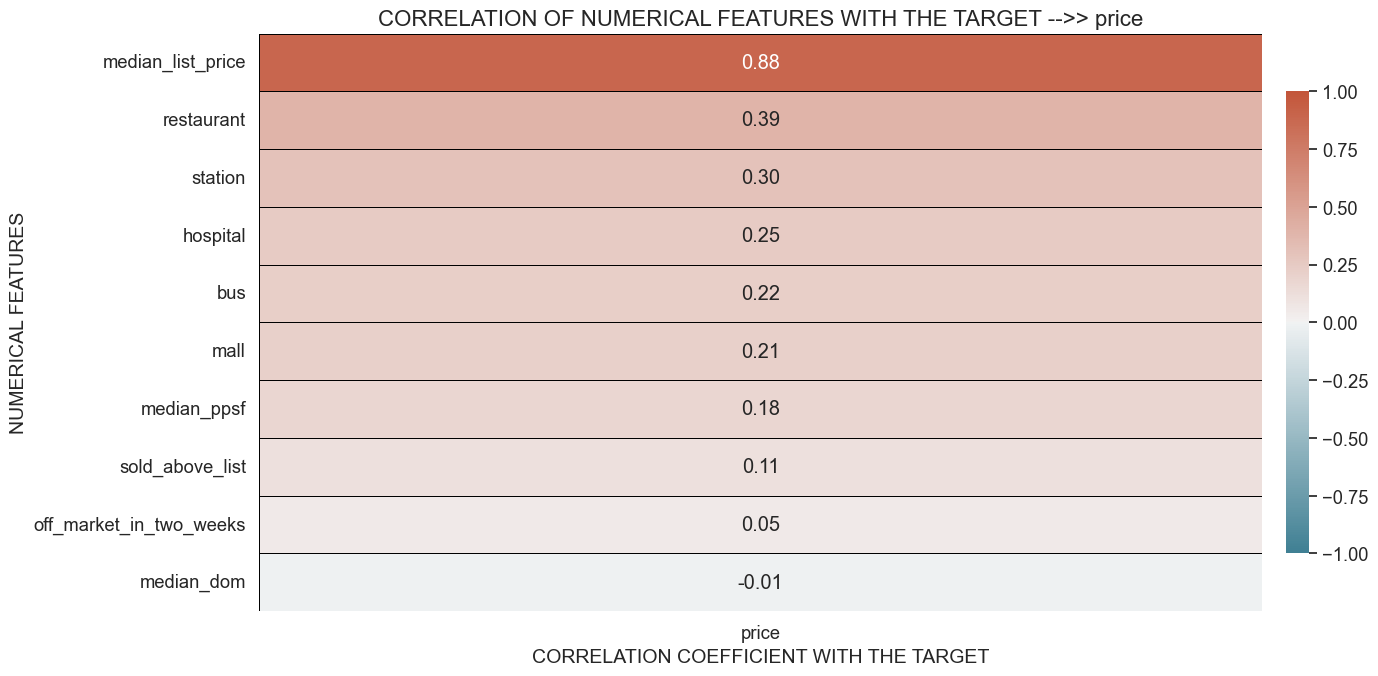

In [24]:
features_correlation_with_target(train_df, target_col="price")

In [25]:
CORRELATED_COLS = ["median_list_price"]

train_df = train_df.drop(columns=CORRELATED_COLS)
eval_df = eval_df.drop(columns=CORRELATED_COLS)
holdout_df = holdout_df.drop(columns=CORRELATED_COLS)
print(f"Train data shape after dropping high correlated features: {train_df.shape}")
print(f"Eval data shape after dropping high correlated features: {eval_df.shape}")
print(f"Holdout data shape after dropping high correlated features: {holdout_df.shape}")

Train data shape after dropping high correlated features: (576815, 12)
Eval data shape after dropping high correlated features: (148448, 12)
Holdout data shape after dropping high correlated features: (148943, 12)


`Removing the feature that is perfectly correlated with the target for the reserved dataset.`

In [26]:
train = train.drop(columns=CORRELATED_COLS)
eval = eval.drop(columns=CORRELATED_COLS)
holdout = holdout.drop(columns=CORRELATED_COLS)
print(f"Train data shape after dropping high correlated features for the reserved dataset: {train.shape}")
print(f"Eval data shape after dropping high correlated features for the reserved dataset: {eval.shape}")
print(f"Holdout data shape after dropping high correlated features for the reserved dataset: {holdout.shape}")

Train data shape after dropping high correlated features for the reserved dataset: (576815, 38)
Eval data shape after dropping high correlated features for the reserved dataset: (148448, 38)
Holdout data shape after dropping high correlated features for the reserved dataset: (148943, 38)


###### UNWANTED COLUMNS

In [27]:
print(train_df.columns)

UNWANTED_COLS = ["city", "city_full"]

Index(['median_ppsf', 'median_dom', 'sold_above_list',
       'off_market_in_two_weeks', 'city', 'bus', 'hospital', 'mall',
       'restaurant', 'station', 'price', 'city_full'],
      dtype='object')


#### FINAL CLEANED AND ENGINEERED FEATURES FOR TRAINING, EVALUATION AND HOLDOUT DATASETS

In [28]:
train_df = train_df.drop(columns=UNWANTED_COLS)
eval_df = eval_df.drop(columns=UNWANTED_COLS)
holdout_df = holdout_df.drop(columns=UNWANTED_COLS)
print(f"Train data shape after dropping final unwanted features: {train_df.shape}")
print(f"Eval data shape after dropping final unwanted features: {eval_df.shape}")
print(f"Holdout data shape after dropping final unwanted features: {holdout_df.shape}")

Train data shape after dropping final unwanted features: (576815, 10)
Eval data shape after dropping final unwanted features: (148448, 10)
Holdout data shape after dropping final unwanted features: (148943, 10)


`FINAL CLEANED AND ENGINEERED FEATURES FOR TRAINING, EVALUATION AND HOLDOUT FOR THE RESERVED DATASETS.`

In [29]:
train = train.drop(columns=UNWANTED_COLS)
eval = eval.drop(columns=UNWANTED_COLS)
holdout = holdout.drop(columns=UNWANTED_COLS)
print(f"Train data shape after dropping final unwanted features for the reserved dataset: {train.shape}")
print(f"Eval data shape after dropping final unwanted features for the reserved dataset: {eval.shape}")
print(f"Holdout data shape after dropping final unwanted features for the reserved dataset: {holdout.shape}")

Train data shape after dropping final unwanted features for the reserved dataset: (576815, 36)
Eval data shape after dropping final unwanted features for the reserved dataset: (148448, 36)
Holdout data shape after dropping final unwanted features for the reserved dataset: (148943, 36)


###### SAVING THE ENGINEERED FEATURES DATASETS

In [30]:
train_df.to_csv("../data/processed_data/engineered_training_data.csv", index=False)
eval_df.to_csv("../data/processed_data/engineered_evaluation_data.csv", index=False)
holdout_df.to_csv("../data/processed_data/engineered_holdout_data.csv", index=False)
print("✅ Engineered Features on Training, evaluation and holdout datasets have been successfully saved.")

✅ Engineered Features on Training, evaluation and holdout datasets have been successfully saved.


`SAVING THE ENGINEERED FEATURES FOR THE RESERVED DATASETS`

In [31]:
train.to_csv("../data/processed_data/engineered_train_df_without_multicoll.csv", index=False)
eval.to_csv("../data/processed_data/engineered_eval_df_without_multicoll.csv", index=False)
holdout.to_csv("../data/processed_data/engineered_holdout_df_without_multicoll.csv", index=False)
print("✅ Engineered Features on Training, evaluation and holdout for reserved datasets have been successfully saved.")

✅ Engineered Features on Training, evaluation and holdout for reserved datasets have been successfully saved.


In [32]:
train.columns

Index(['month', 'quarter', 'year', 'median_ppsf', 'homes_sold',
       'pending_sales', 'new_listings', 'inventory', 'median_dom',
       'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks',
       'zipcode', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school',
       'station', 'Total Population', 'Median Age', 'Per Capita Income',
       'Total Families Below Poverty', 'Total Housing Units', 'Median Rent',
       'Total Labor Force', 'Unemployed Population',
       'Total School Age Population', 'Total School Enrollment',
       'Median Commute Time', 'price', 'lat', 'lng', 'zipcode_freq',
       'city_full_encoded'],
      dtype='object')

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576815 entries, 0 to 576814
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   month                         576815 non-null  int32  
 1   quarter                       576815 non-null  int32  
 2   year                          576815 non-null  int32  
 3   median_ppsf                   576815 non-null  float64
 4   homes_sold                    576815 non-null  float64
 5   pending_sales                 576815 non-null  float64
 6   new_listings                  576815 non-null  float64
 7   inventory                     576815 non-null  float64
 8   median_dom                    576815 non-null  float64
 9   avg_sale_to_list              576815 non-null  float64
 10  sold_above_list               576815 non-null  float64
 11  off_market_in_two_weeks       576815 non-null  float64
 12  zipcode                       576815 non-nul